## [GitHub url](https://github.com/sunjungAn/Deep_Learning)

# 1.Settings

### 1) Important required libraries

In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter


In [67]:
batch_size = 16
learning_rate = 0.001
epoch = 20

n_node = 1024
dropratio = 0.5

imgsize= 256

# 2. Data Loader
### 트레이닝 데이터

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [68]:
img_dir = "/content/drive/MyDrive/fruit/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                           transforms.CenterCrop(imgsize*2),
                                                           transforms.RandomCrop(imgsize),
                                                           transforms.RandomHorizontalFlip(),

                                                           transforms.Resize(imgsize),
                                                           transforms.ToTensor()]))

print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size, shuffle = False, num_workers =2 )

409


### 고정된 데이터 셋

In [69]:
img_dir = "/content/drive/MyDrive/fruit/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                         transforms.CenterCrop(size = imgsize),
                                                         transforms.Resize(imgsize),
                                                         transforms.ToTensor()
]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [70]:
img_dir = "/content/drive/MyDrive/fruit/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                         transforms.CenterCrop(size = imgsize),
                                                         transforms.Resize(imgsize),
                                                         transforms.ToTensor()
]))

test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [71]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 2
['apple', 'orange']
{'apple': 0, 'orange': 1}
409
Training: 409, Dev: 130, Test: 136


In [72]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['apple', 'orange']
['apple', 'orange']
['apple', 'orange']


## 3. Model

### 1) Pretrained VGG Model

In [73]:
vgg = models.vgg19(pretrained = True)

for name, module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

print(list(vgg.children())[0][0])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [74]:
base_dim = 64
fsize = imgsize//32

class MyVGG(nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    self.layer0 = nn.Sequential(*list(vgg.children())[0])

    self.layer1 = nn.Sequential(
        nn.Linear(8*base_dim * fsize * fsize, n_node), #중요
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, nclass),#중요
    )
    for m in self.layer1.modules():
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self, x):
    # layer0의 사이즈를 프린트하여 알아낼 수 있음(batchsize, x, x,x )
    # print(x.size())
    out = self.layer0(x)
    out = out.view(out.size(0), -1)
    out = self.layer1(out)
    return out


### 3) Model on GPU

In [75]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
  params.required_grad = False

for params in model.layer1.parameters():
  params.required_grad = True

for name in model.children():
  print(name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [76]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate)

## 5. Train

In [77]:
import utils

total_time = 0
disp_step = 10

to_train = True
if(to_train ==False):
  netname = "catdog_vgg19_10.pkl"
  model = torch.load(netname)
else:
  print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
  model.eval()
  train_corr = utils.ComputeCorr(train_batch, model)
  dev_corr = utils.ComputeCorr(dev_batch, model)
  test_corr = utils.ComputeCorr(test_batch, model)

  print("Correct of train: %.2f, dev: %.2f, test: %.2f"%(train_corr, dev_corr, test_corr))
  model.train()

  netname = "catdog_vgg19"

  x_epoch = []
  y_train_err = []
  y_dev_err = []
  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100.0 - train_corr)
  y_dev_err.append(100.0 - dev_corr)
  y_test_err.append(100.0 - test_corr)

  for i in range(epoch):
    start_time = time.time()
    print("%d.." %i),
    for img,label in train_batch:
      img = Variable(img).cuda()
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output, label)
      loss.backward()
      optimizer.step()

    end_time = time.time()
    duration = end_time - start_time
    total_time += duration
    if (i % disp_step == 0) or (i == epoch -1):
      torch.save(model, netname+"_%d.pkl"%i,)
      print("\n[%d/%d] loss: %.3f, "%(i, epoch, (loss.cpu()).data.numpy())),
      model.eval()

      train_corr = utils.ComputeCorr(train_batch, model)
      dev_corr = utils.ComputeCorr(dev_batch, model)
      test_corr = utils.ComputeCorr(test_batch, model)
      print("Correct of train: %.2f, dev: %.2f, test: %.2f,"%(train_corr, dev_corr, test_corr)),
      model.train()
      print("time: %.2f sec..." %(total_time))

      x_epoch.append(i+1)
      y_train_err.append(100.0 - train_corr)
      y_dev_err.append(100.0 - dev_corr)
      y_test_err.append(100.0 - test_corr)
  print("Total time: %.2f sec" %total_time)
    

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 46.45, dev: 43.85, test: 48.53
0..

[0/20] loss: 1.139, 
Correct of train: 49.39, dev: 51.54, test: 52.21,
time: 8.44 sec...
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.415, 
Correct of train: 51.83, dev: 55.38, test: 52.94,
time: 93.37 sec...
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.275, 
Correct of train: 49.63, dev: 53.08, test: 47.79,
time: 169.59 sec...
Total time: 169.59 sec


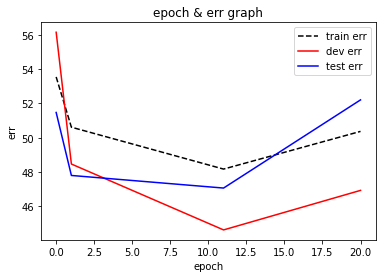

In [78]:
if(to_train):
  plt.plot(x_epoch, y_train_err, color = "black", label = "train err", linestyle = '--')
  plt.plot(x_epoch, y_dev_err, color = "red", label= "dev err")
  plt.plot(x_epoch, y_test_err, color = "blue",label = "test err")

  plt.xlabel("epoch")
  plt.ylabel("err")
  plt.title("epoch & err graph")
  plt.legend(loc = "upper right")
  plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


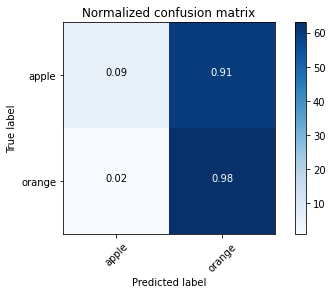

Confusion matrix, without normalization


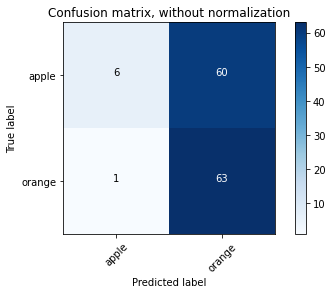

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.53 |	 0.86 |	 0.09 |	 0.16
 orange: 0.53 |	 0.51 |	 0.98 |	 0.67
*accuracy: 0.53, precision: 0.68, recall: 0.54, *f1 score: 0.42
[AP]
apple: 0.66
orange: 0.53

[mAP] 0.593
[miAP] 0.765


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.81615835, 0.54247481, 0.50366914, 0.53375   , 0.56523383,
        0.50804597, 0.52953321, 0.5817495 , 0.606531

In [79]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


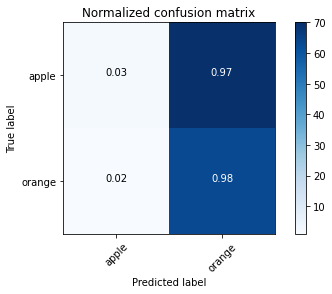

Confusion matrix, without normalization


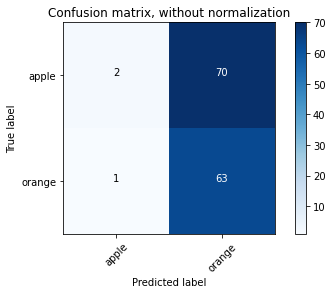

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.48 |	 0.67 |	 0.03 |	 0.05
 orange: 0.48 |	 0.47 |	 0.98 |	 0.64
*accuracy: 0.48, precision: 0.57, recall: 0.51, *f1 score: 0.35
[AP]
apple: 0.64
orange: 0.56

[mAP] 0.600
[miAP] 0.739


In [80]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: apple
 True predicted images/total apple category: 6 / 66
Predicted probability:
[0.56082505 0.43917495]


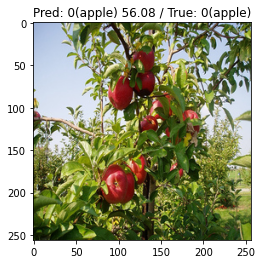

Predicted probability:
[0.5187045  0.48129553]


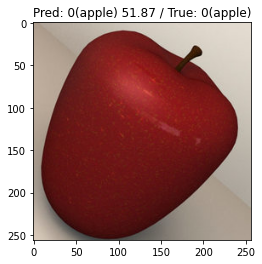

 False predicted images/total apple category: 60 / 66
Predicted probability:
[0.18384163 0.81615835]


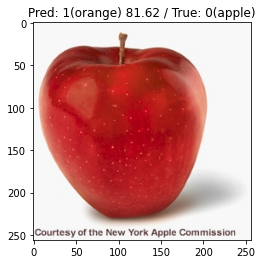

Predicted probability:
[0.4575252 0.5424748]


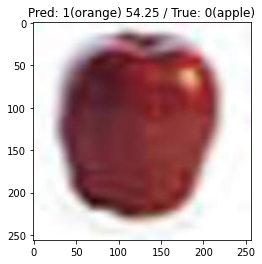

Category: orange
 True predicted images/total orange category: 63 / 64
Predicted probability:
[0.41432342 0.5856766 ]


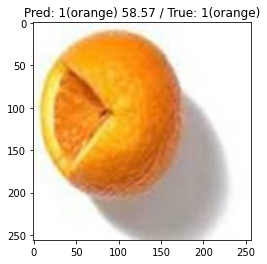

Predicted probability:
[0.17060834 0.82939166]


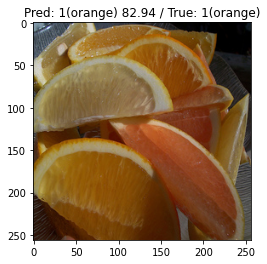

 False predicted images/total orange category: 1 / 64
Predicted probability:
[0.50400573 0.4959943 ]


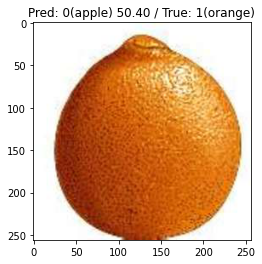

In [81]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n = 2)